<a href="https://colab.research.google.com/github/HeniSoula/IAM/blob/main/Projet_FullySupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RandAugment

In [ ]:
!pip uninstall --yes imgaug
!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 7.3 MB/s 


In [ ]:
import imgaug.augmenters as iaa
aug = iaa.RandAugment(n=2, m=9)

def randaugment(img):
  return aug(images=img)

# Chargement des données

In [ ]:
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

Cloning into 'projsemisup'...
remote: Enumerating objects: 48161, done.
remote: Total 48161 (delta 0), reused 0 (delta 0), pack-reused 48161
Receiving objects: 100% (48161/48161), 2.96 GiB | 23.17 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (22857/22857), done.


In [ ]:
import os

CLASSES = os.listdir(path + 'Lab/')
print(CLASSES)

['hyène', 'Leopard', 'Hippopotame', 'Zèbre', 'Gnou', 'Chimpanzé', 'Guepard', 'Chacal', 'tigre', 'Elephant', 'Phacochère', 'autruche', 'Girafe', "Buffle d'Afrique", 'Lion', 'Gorilla', 'antilope', 'Rhinoceros']


In [ ]:
IMAGE_SIZE = 64

In [ ]:
import os
import PIL
from PIL import Image
import numpy as np

def load_semisup_data(path, classes, image_size=64):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 360
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 1800
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1


  return x_lab, y_lab, x_test, y_test


x_lab, y_lab, x_test, y_test = load_semisup_data(path, CLASSES, image_size=IMAGE_SIZE)


In [ ]:
print(x_lab.shape, y_lab.shape)
print(x_test.shape, y_test.shape)

(360, 64, 64, 3) (360, 1)
(1800, 64, 64, 3) (1800, 1)


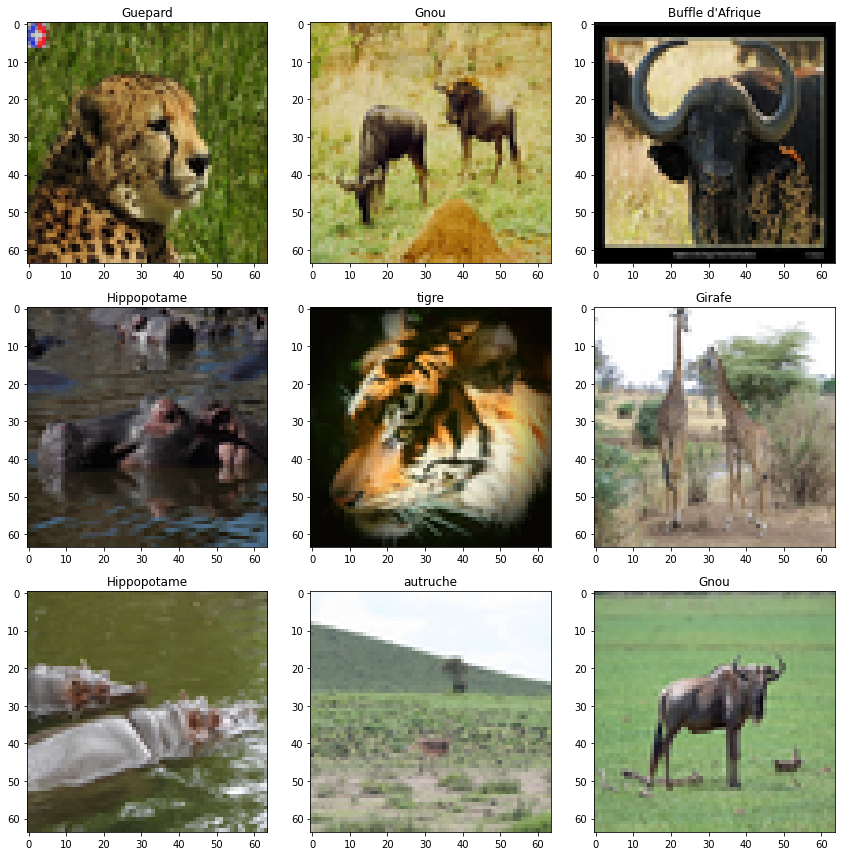

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images aléatoires de la base d'apprentissage
indices = np.arange(x_lab.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y_lab[indices[i]])])
    plt.imshow(x_lab[indices[i]]/255)
plt.tight_layout()
plt.show()

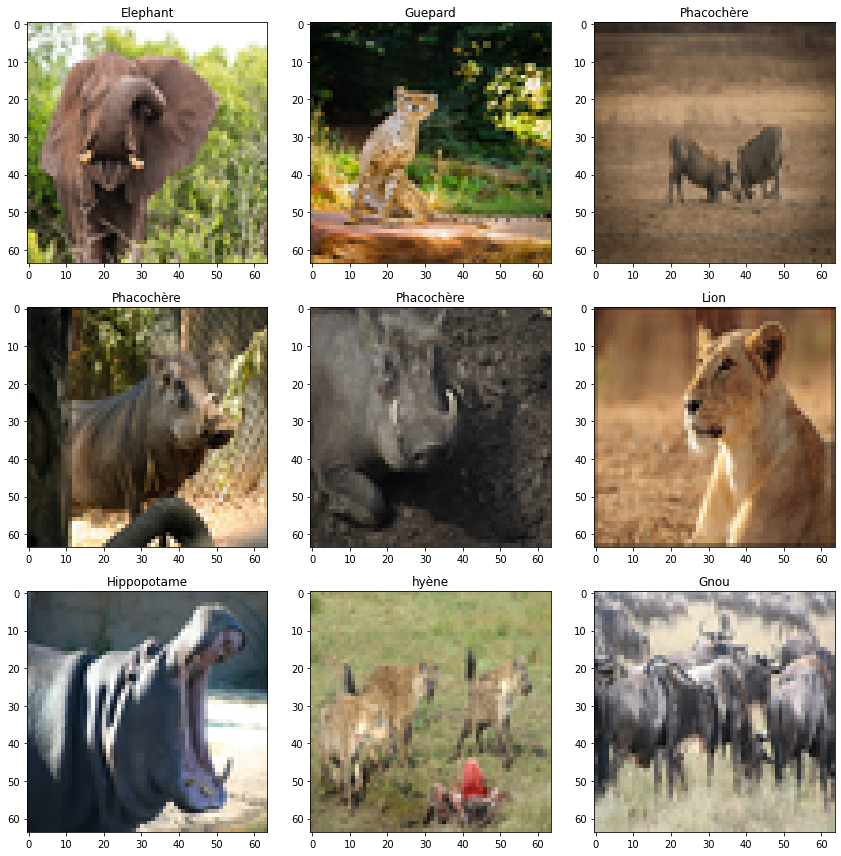

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images aléatoires de la base de test
indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y_test[indices[i]])])
    plt.imshow(x_test[indices[i]]/255)
plt.tight_layout()
plt.show()

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

def create_model(image_size=64):
  model = Sequential()

  model.add(Conv2D(64,(3,3),input_shape=(image_size,image_size,3),activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(18,activation='softmax'))

  return model

# Apprentissage supervisé avec augmentation

In [19]:
import tensorflow as tf
from tensorflow import keras
import math

x_train_lab = x_lab
y_train_lab = y_lab

# Hyperparamètres de l'apprentissage
epochs = 200
batch_size = 16
steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)

model = create_model(image_size=IMAGE_SIZE)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble labellisé
indices = np.arange(x_train_lab.shape[0])

# Boucle sur les epochs
for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices) 

  # Et on recommence à cumuler la loss
  cum_loss_value = 0

  for step in range(steps_per_epoch):

    # Sélection des données du prochain batch
    x_batch = x_train_lab[indices[step*batch_size:(step+1)*batch_size]]
    y_batch = y_train_lab[indices[step*batch_size:(step+1)*batch_size]]

    # Augmentation puis des données
    x_batch_augment = randaugment(x_batch.astype('uint8'))
    x_batch_augment = x_batch_augment.astype('float')/255

    # Etape nécessaire pour comparer y_batch à la sortie du réseau
    y_batch = np.expand_dims(y_batch, 1)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch_augment, training=True)  # Logits for this minibatch

      # Calcul de la fonction de perte sur ce batch
      loss_value = loss_fn(y_batch, y_pred)

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch, y_pred)

      cum_loss_value = cum_loss_value + loss_value

  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()

  if epoch%5 == 0:
    # Calcul de la précision sur l'ensemble de test à la fin de l'epoch, toutes les 5 epochs
    test_logits = model(x_test/255, training=False)
    test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
    test_acc = test_acc_metric.result()

    print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(train_acc), float(test_acc)))

  else:
    print("Epoch %4d : Loss : %.4f, Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(train_acc)))


  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()      

Epoch    0 : Loss : 2.9078, Acc : 0.0398, Test Acc : 0.0556
Epoch    1 : Loss : 2.8915, Acc : 0.0483
Epoch    2 : Loss : 2.8892, Acc : 0.0739
Epoch    3 : Loss : 2.8873, Acc : 0.0710
Epoch    4 : Loss : 2.8839, Acc : 0.0994
Epoch    5 : Loss : 2.8819, Acc : 0.0881, Test Acc : 0.0928
Epoch    6 : Loss : 2.8736, Acc : 0.0994
Epoch    7 : Loss : 2.8607, Acc : 0.0625
Epoch    8 : Loss : 2.8368, Acc : 0.0852
Epoch    9 : Loss : 2.7486, Acc : 0.1392
Epoch   10 : Loss : 2.7422, Acc : 0.1335, Test Acc : 0.1361
Epoch   11 : Loss : 2.6405, Acc : 0.1705
Epoch   12 : Loss : 2.6638, Acc : 0.1335
Epoch   13 : Loss : 2.6664, Acc : 0.1676
Epoch   14 : Loss : 2.6347, Acc : 0.1875
Epoch   15 : Loss : 2.5450, Acc : 0.2131, Test Acc : 0.1511
Epoch   16 : Loss : 2.5305, Acc : 0.2102
Epoch   17 : Loss : 2.5975, Acc : 0.1790
Epoch   18 : Loss : 2.4823, Acc : 0.2358
Epoch   19 : Loss : 2.4338, Acc : 0.2472
Epoch   20 : Loss : 2.4588, Acc : 0.2330, Test Acc : 0.1822
Epoch   21 : Loss : 2.4059, Acc : 0.2358
Epo

In [15]:
import os
import PIL
from PIL import Image
import numpy as np

def load_full_data(path, classes, image_size=64):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 360
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 1800
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1

  file_path_unlab = os.listdir(path + 'Unlab/')
  nb_unlab = 20697
  # Initialise les structures de données
  x_unlab = np.zeros((nb_unlab, image_size, image_size, 3))
  i = 0
  for c in file_path_unlab:
    # Lecture de l'image
    img = Image.open(path + 'Unlab/' + c)
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x_unlab[i] = np.asarray(img)
    i = i + 1


  return x_lab, y_lab, x_test, y_test, x_unlab


x_lab, y_lab, x_test, y_test, x_unlab = load_full_data(path, CLASSES, image_size=IMAGE_SIZE)

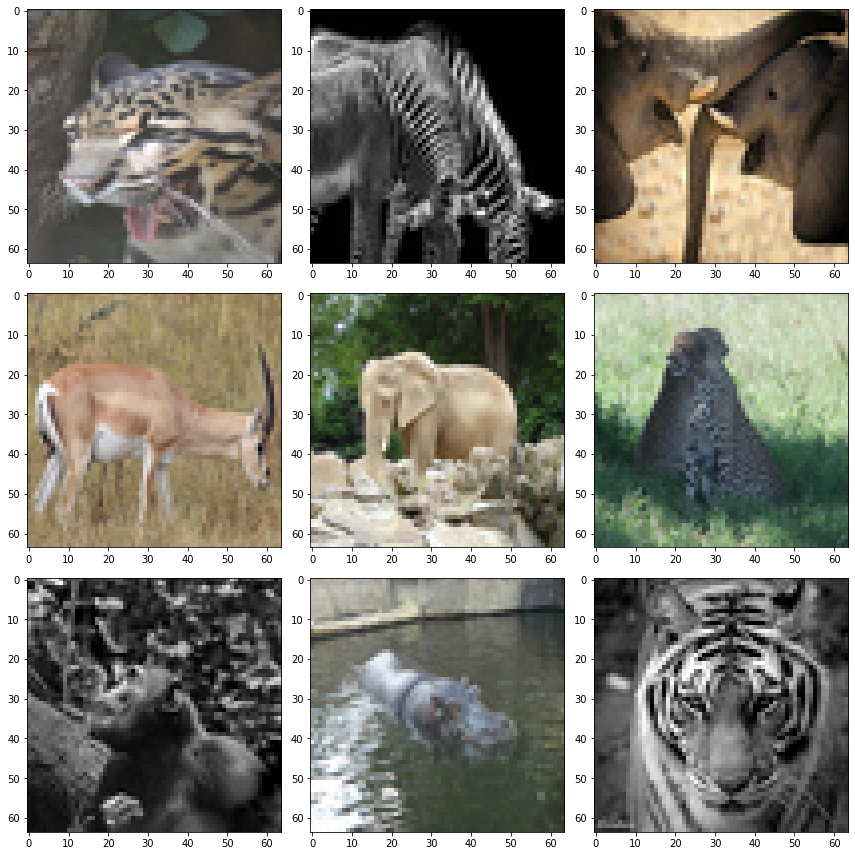

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images aléatoires de la base d'apprentissage
indices = np.arange(x_unlab.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_unlab[indices[i]]/255)
plt.tight_layout()
plt.show()

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model

# Nombre d'epochs de l'apprentissage
epochs = 2000
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 10
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

model = create_model()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=3e-5)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT : 
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()
# L'autre pour la partie non-supervisée de la perte
loss_unsup =  keras.losses.MeanSquaredError()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_lab.shape[0]) 
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_unlab.shape[0]) 

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)/255

    # On forme également un batch alternatif constitué des mêmes données bruitées
    # Le bruit ici sera simplement obtenu avec np.rand()
    # Attention à l'échelle du bruit !
    x_batch_noisy = x_batch + 0.5*(np.random.rand(*x_batch.shape)-0.5)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !  
      y_pred_noisy = model(x_batch_noisy, training=True)  

      # Calcul de la fonction de perte sur ce batch
      sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])/bs_lab
      unsup_term = loss_unsup(y_pred_noisy, y_pred)

      loss_value = sup_term + lambda_t*unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])

  
  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test/255, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 10:
      lambda_t = lambda_t + 0.001

Epoch    0 : Loss : 0.2935, Acc : 0.0000, Val Acc : 0.0544
Epoch    1 : Loss : 0.2918, Acc : 0.0306, Val Acc : 0.0556
Epoch    2 : Loss : 0.2910, Acc : 0.0417, Val Acc : 0.0561
Epoch    3 : Loss : 0.2903, Acc : 0.0639, Val Acc : 0.0561
Epoch    4 : Loss : 0.2900, Acc : 0.0639, Val Acc : 0.0550
Epoch    5 : Loss : 0.2895, Acc : 0.0722, Val Acc : 0.0561
Epoch    6 : Loss : 0.2891, Acc : 0.0722, Val Acc : 0.0572
Epoch    7 : Loss : 0.2889, Acc : 0.0806, Val Acc : 0.0594
Epoch    8 : Loss : 0.2885, Acc : 0.0944, Val Acc : 0.0633
Epoch    9 : Loss : 0.2880, Acc : 0.1000, Val Acc : 0.0917
Epoch   10 : Loss : 0.2876, Acc : 0.1250, Val Acc : 0.0967
Epoch   11 : Loss : 0.2869, Acc : 0.1556, Val Acc : 0.1022
Epoch   12 : Loss : 0.2863, Acc : 0.1500, Val Acc : 0.1156
Epoch   13 : Loss : 0.2857, Acc : 0.1500, Val Acc : 0.1311
Epoch   14 : Loss : 0.2852, Acc : 0.1500, Val Acc : 0.1256
Epoch   15 : Loss : 0.2853, Acc : 0.1750, Val Acc : 0.1156
Epoch   16 : Loss : 0.2848, Acc : 0.1833, Val Acc : 0.09

KeyboardInterrupt: ignored